In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib.cm as cm
import time,os,subprocess
import copy
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
import scipy.interpolate as interpolate
#import pyart.graph.cm as pcm
import pickle
import datetime
import pims
import pandas as pd
#import trackpy as tp
from PIL import Image
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine
%matplotlib inline

ModuleNotFoundError: No module named 'marcus_py_tools'

In [52]:
khgx_lat = 29.468
khgx_lon = -95.075

In [13]:
filenm = '/home/mvanlier/Research/Houston_track/refl_long_storm.csv'
df = pd.read_csv(filenm)
print(df)

     scan  uid   area   grid_x   grid_y isolated      lat      lon        max  \
0       0    0  10.25  367.976  157.073     True  28.3791 -95.2423  41.128731   
1       0    1  14.25  292.754  189.789     True  28.5265 -95.6263  45.238003   
2       0    2  20.75  610.855  521.470     True  30.0115 -93.9830  52.002148   
3       0    3  40.50  697.926  606.025     True  30.3892 -93.5253  50.663036   
4       1    0  16.00  368.312  158.766     True  28.3881 -95.2423  39.801807   
5       1    1  11.25  291.267  192.800     True  28.5399 -95.6366  43.452705   
6       1    2  14.25  611.018  525.737     True  30.0340 -93.9828  48.598919   
7       1    3  35.00  697.336  608.529     True  30.4027 -93.5303  47.909958   
8       2    0  20.25  367.753  161.914     True  28.4016 -95.2423  44.664429   
9       2    2  13.25  610.962  527.604     True  30.0430 -93.9827  47.161983   
10      2    3  28.25  696.814  610.726     True  30.4117 -93.5302  46.038994   
11      3    0   9.25  365.7

In [70]:
print((df[df['uid']==0]))

     scan  uid    area   grid_x   grid_y isolated      lat      lon  \
0       0    0   10.25  367.976  157.073     True  28.3791 -95.2423   
4       1    0   16.00  368.312  158.766     True  28.3881 -95.2423   
8       2    0   20.25  367.753  161.914     True  28.4016 -95.2423   
11      3    0    9.25  365.730  168.919    False  28.4331 -95.2526   
15      4    0   13.50  362.037  174.685     True  28.4600 -95.2731   
18      5    0   10.00  355.750  185.750     True  28.5094 -95.3039   
20      6    0   31.50  337.111  191.484     True  28.5317 -95.4012   
23      7    0   34.00  335.971  194.324     True  28.5452 -95.4063   
26      8    0   70.00  331.146  203.375     True  28.5856 -95.4321   
31      9    0   98.50  328.246  209.652     True  28.6170 -95.4475   
37     10    0  107.00  325.678  215.488     True  28.6395 -95.4579   
49     11    0  105.25  323.976  218.309     True  28.6530 -95.4682   
60     12    0  115.75  321.996  225.778    False  28.6889 -95.4785   
74    

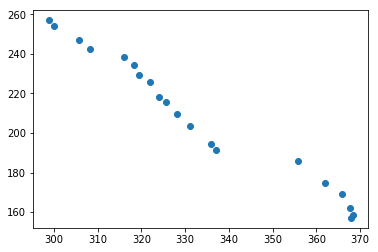

In [34]:
plt.scatter(df[df['uid']==0]['grid_x'],df[df['uid']==0]['grid_y'])

In [48]:
print(df[df['uid']==0]['time'][0][-8:])
stub = df[df['uid']==0]['time'][0]
print('KHGX_grid_'+stub[-19:-15]+stub[-14:-12]+stub[-11:-9]+'.'+stub[-8:-6]+stub[-5:-3]+stub[-2:])
print('KHGX_grid_20151124.193709.nc')
datapath='/lcrc/group/earthscience/radar/houston/data/'
gridpre='KHGX_grid_'
gridsuf='.nc'
stub=df[df['uid']==0]['time'][0]
timstr = stub[-19:-15]+stub[-14:-12]+stub[-11:-9]+'.'+stub[-8:-6]+stub[-5:-3]+stub[-2:]
print(datapath+stub[-19:-15]+stub[-14:-12]+stub[-11:-9]+'/'+gridpre+timstr+gridsuf)
print(timstr[0:8])

18:23:28
KHGX_grid_20150709.182328
KHGX_grid_20151124.193709.nc
/lcrc/group/earthscience/radar/houston/data/20150709/KHGX_grid_20150709.182328.nc
20150709


In [61]:
nc = Dataset('/home/mvanlier/Research/Houston_track/KHGX_grid_20160811.191353.nc','r')
xd = nc.variables['x'][:]
yd = nc.variables['y'][:]
zd = nc.variables['z'][:]
radlat = nc.variables['radar_latitude'][0]
radlon = nc.variables['radar_longitude'][0]
nc.close()
latgrid,longrid = latlon_from_xy(xd,yd,khgx_lat,khgx_lon)
print(latgrid.shape)
print(radlat,radlon)
#print(xd)

(801, 801)
29.4719009399 -95.0787353516


In [50]:
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def latlon_from_xy(xd,yd,lat_c,lon_c):
    import pyproj
    #..Make a grids latgrid(x,y) and longrid(x,y) from x and y displacements
    g = pyproj.Geod(ellps='clrk66')
    #..Uses pyproj geod
    lat = np.empty([len(yd),len(xd)])
    lon = np.empty([len(yd),len(xd)])
    #..cacalate azimuth between radar and point
    for j in range(len(yd)):
        for i in range(len(xd)):
            faz = np.arctan2(xd[i],yd[j])
            dist = np.hypot(xd[i],yd[j])
            lon[j,i],lat[j,i],baz = g.fwd(lon_c,lat_c,180.*faz/np.pi,dist)
    return lat,lon

In [51]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800. # Earth radius in kilometers
        
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
                            
    a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
                                        
    return R * c

In [76]:
def track_statistics(df, tr, dist_to_khgx_thresh=120000., mask_rhothresh=0.8, mask_dbzthresh=15., 
                     distradius=5000., kdpthr=0.5, zdrthr=0.75, pctile=98.,verbose=True,
                     datapath='/lcrc/group/earthscience/radar/houston/data/',gridpre='KHGX_grid_',gridsuf='.nc',
                     save_timeseries=False, return_timeseries=False, return_scalar=True, 
                     zmelt_idx = 9, an_nlayers = 8):
    #..This code is to assemble statistics of:
    #..     - ZDR PE 
    #..     - KDP PE
    #..     - ZHH PE
    #..     - ??th percentile KDP
    #..     - ??th percentile ZDR
    #..     - ??th percentile ZHH
    ntr = len(df[df['uid']==tr])
    if verbose:
        print('length of track no. ',tr,' = ',ntr)
    #..Get pathlist to get grid
    pathlist = []
    for i in range(ntr):
        print(df[df['uid']==tr]['time'][i][:])
        stub=df[df['uid']==tr]['time'][i]
        timstr = stub[-19:-15]+stub[-14:-12]+stub[-11:-9]+'.'+stub[-8:-6]+stub[-5:-3]+stub[-2:]
        pathlist.append(datapath+timstr[0:8]+'/'+gridpre+timstr+gridsuf)
        
    #..Load one file to get lat/lon etc
    nc = Dataset(pathlist[0],'r')
    xd = nc.variables['x'][:]
    yd = nc.variables['y'][:]
    zd = nc.variables['z'][:]
    rad_lat = nc.variables['radar_latitude'][0]
    rad_lon = nc.variables['radar_longitude'][0]
    nc.close()
    zgrid = np.zeros((len(zd),len(yd),len(xd)))
    for j in range(len(zd)):
        zgrid[j,:,:] = zd[j]
    latgrid,longrid = latlon_from_xy(xd,yd,rad_lat,rad_lon)
    d2radgrid = copy.deepcopy(latgrid)
    d2radgrid = 0.
    for i in range(latgrid.shape[0]):
        d2radgrid[:,i] = np.sqrt(xd[i]**2+yd[:]**2)
    #..For all steps in path, aggregate statistics and save
    kdp_pe = []
    zdr_pe = []
    zhh_pe = []
    kdp_pct = []
    zdr_pct = []
    zhh_pct = []
    
    for i in range(ntr):
        tlat = df[df['uid']==tr]['lat'][i]
        tlon = df[df['uid']==tr]['lon'][i]
        dist_to_center = haversine(lat_grid,lon_grid,tlat,tlon)
        #..
        nc  = Dataset(pathlist[i],'r')
        zhh = nc.variables['reflectivity'][0,:,:,:]
        zdr = nc.variables['differential_reflectivity'][0,:,:,:]
        kdp = nc.variables['specific_differential_phase'][0,:,:,:]
        rho = nc.variables['cross_correlation_ratio'][0,:,:,:]
        nc.close()
        #..
        kdp_proc = np.ma.masked_values(kdp,-9999.)
        kdp_proc = np.ma.masked_where(np.logical_or(rho<mask_rhothresh,zhh<mask_dbzthresh),kdp_proc)
        zdr_proc = np.ma.masked_values(zdr,-9999.)
        zdr_proc = np.ma.masked_where(np.logical_or(rho<mask_rhothresh,zhh<mask_dbzthresh),zdr_proc)
        zhh_proc = np.ma.masked_values(zhh,-9999.)
        #..
        logconi = dist_to_center<distradius
        vol_ones = zdr_proc*0.+1
        kdp_pct = np.r_[kdp_pct,np.percentile(kdp_proc[zmelt_idx:zmelt_idx+an_nlayers+1,logconi],pctile)]
        zdr_pct = np.r_[zdr_pct,np.percentile(zdr_proc[zmelt_idx:zmelt_idx+an_nlayers+1,logconi],pctile)]
        zhh_pct = np.r_[zhh_pct,np.percentile(zhh_proc[zmelt_idx:zmelt_idx+an_nlayers+1,logconi],pctile)]
        #print kdp_99p
        kdp_pei = kdp_proc*zgrid
        zdr_pei = zdr_proc*zgrid
        zhh_pei = zhh_proc*zgrid
        if not(bool(vol_ones[zmelt_idx:zmelt_idx+an_nlayers+1,logconi].sum()>0.)):
            print('isempty')
            kdp_pet = 0.
            zdr_pet = 0.
            zhh_pet = 0.
        else:
            kdp_pet = kdp_pei[zmelt_idx:zmelt_idx+an_nlayers+1,
                              logconi].sum()/vol_ones[zmelt_idx:zmelt_idx+an_nlayers+1,logconi].sum()
            zdr_pet = zdr_pei[zmelt_idx:zmelt_idx+an_nlayers+1,
                              logconi].sum()/vol_ones[zmelt_idx:zmelt_idx+an_nlayers+1,logconi].sum()
            zhh_pet = zhh_pei[zmelt_idx:zmelt_idx+an_nlayers+1,
                              logconi].sum()/vol_ones[zmelt_idx:zmelt_idx+an_nlayers+1,logconi].sum()
        try:
            kdp_pe = np.r_[kdp_pe,kdp_pet]
        except ValueError:
            kdp_pe = np.r_[kdp_pe,-99.]
        try:
            zdr_pe = np.r_[zdr_pe,zdr_pet]
        except ValueError:
            zdr_pe = np.r_[zdr_pe,-99.]
        try:
            zhh_pe = np.r_[zhh_pe,zhh_pet]
        except ValueError:
            zhh_pe = np.r_[zhh_pe,-99.]
    #..
    if save_timeseries:
        saved_track_stats = {"kdp_pe":kdp_pe,"zdr_pe":zdr_pe,"zhh_pe":zhh_pe,
                             "kdp_pct":kdp_pct,"zdr_pct":zdr_pct,"zhh_pct":zhh_pct}
        pickle.dump( saved_track_stats, open("trackstats_"+timstr[0:8]+'_tr'+str(tr).zfill(3),'rb'))
    #..
    if return_timeseries:
        return kdp_pe, zhh_pe, kdp_pct, zhh_pct
    elif return_scalar:
        return kdp_pet.max(),zdr_pet.max(),zhh_pet.max(),kdp_pe.max(),zdr_pe.max(),zhh_pe.max()
    #..

In [77]:
kdp_pe,zhh_pe, kdp_pct, zhh_pct = track_statistics(df, 0, datapath='/home/mvanlier/Research/Houston_track/',
                 return_timeseries=True, return_scalar=False)

length of track no.  0  =  20
2015-07-09 18:23:28


KeyError: 1